In [ ]:
from google.colab import files
files.upload() ## Upload your kaggle.json here
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!mkdir FruitRecognition
%cd FruitRecognition
!pwd #Print Working Directory
!kaggle datasets download -d utkarshsaxenadn/fruits-classification


In [ ]:
!unzip fruits-classification.zip

In [3]:
import keras, os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import regularizers
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from glob import glob
from IPython.display import display, Markdown, Latex
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
trainpaths=[]
for name in glob('/content/FruitRecognition/Fruits Classification/train/*', recursive=True):
  if not name.endswith('.zip'):
    trainpaths.append(name)
valpaths=[]
for name in glob('/content/FruitRecognition/Fruits Classification/valid/*', recursive=True):
  if not name.endswith('.zip'):
    valpaths.append(name)
testpaths=[]
for name in glob('/content/FruitRecognition/Fruits Classification/test/*', recursive=True):
  if not name.endswith('.zip'):
    testpaths.append(name)
print(trainpaths)
print(valpaths)
print(testpaths)

['/content/FruitRecognition/Fruits Classification/train/Grape', '/content/FruitRecognition/Fruits Classification/train/Mango', '/content/FruitRecognition/Fruits Classification/train/Apple', '/content/FruitRecognition/Fruits Classification/train/Banana', '/content/FruitRecognition/Fruits Classification/train/Strawberry']
['/content/FruitRecognition/Fruits Classification/valid/Grape', '/content/FruitRecognition/Fruits Classification/valid/Mango', '/content/FruitRecognition/Fruits Classification/valid/Apple', '/content/FruitRecognition/Fruits Classification/valid/Banana', '/content/FruitRecognition/Fruits Classification/valid/Strawberry']
['/content/FruitRecognition/Fruits Classification/test/Grape', '/content/FruitRecognition/Fruits Classification/test/Mango', '/content/FruitRecognition/Fruits Classification/test/Apple', '/content/FruitRecognition/Fruits Classification/test/Banana', '/content/FruitRecognition/Fruits Classification/test/Strawberry']


In [5]:
train_img_paths=[]
train_labels=[]
for i in trainpaths:
  for name in glob(i+'/*'):
    a=name.split('/')
    train_img_paths.append(name)
    train_labels.append(a[-2])

val_img_paths=[]
val_labels=[]
for i in valpaths:
  for name in glob(i+'/*'):
    a=name.split('/')
    val_img_paths.append(name)
    val_labels.append(a[-2])

test_img_paths=[]
test_labels=[]
for i in testpaths:
  for name in glob(i+'/*'):
    a=name.split('/')
    test_img_paths.append(name)
    test_labels.append(a[-2])

print(len(train_img_paths))
print(len(val_img_paths))
print(len(test_img_paths))
print(set(train_labels))

9700
200
100
{'Banana', 'Apple', 'Grape', 'Strawberry', 'Mango'}


#*Count Plot of Train data in data set:*

<Axes: xlabel='1', ylabel='count'>

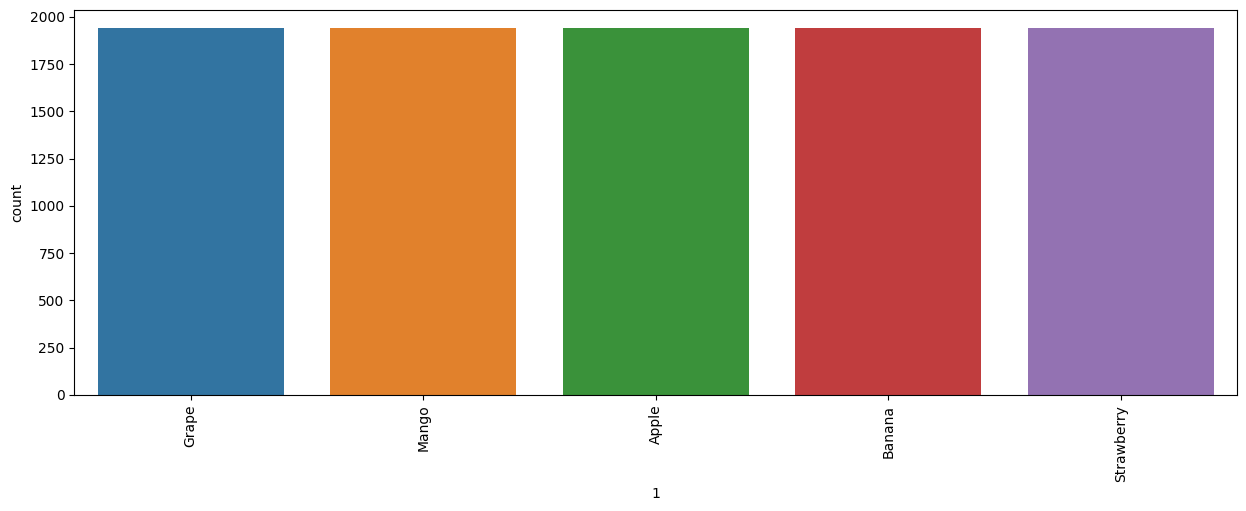

In [6]:
trainImgPath = pd.Series(train_img_paths).astype(str)
trainLabels=pd.Series(train_labels)
trainData = pd.concat([trainImgPath,trainLabels],axis=1)
display(Markdown("#*Count Plot of Train data in data set:*"))
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
sns.countplot(x=trainData[1], order=trainData[1].value_counts().index)

#*Count Plot of Validation data in data set:*

<Axes: xlabel='1', ylabel='count'>

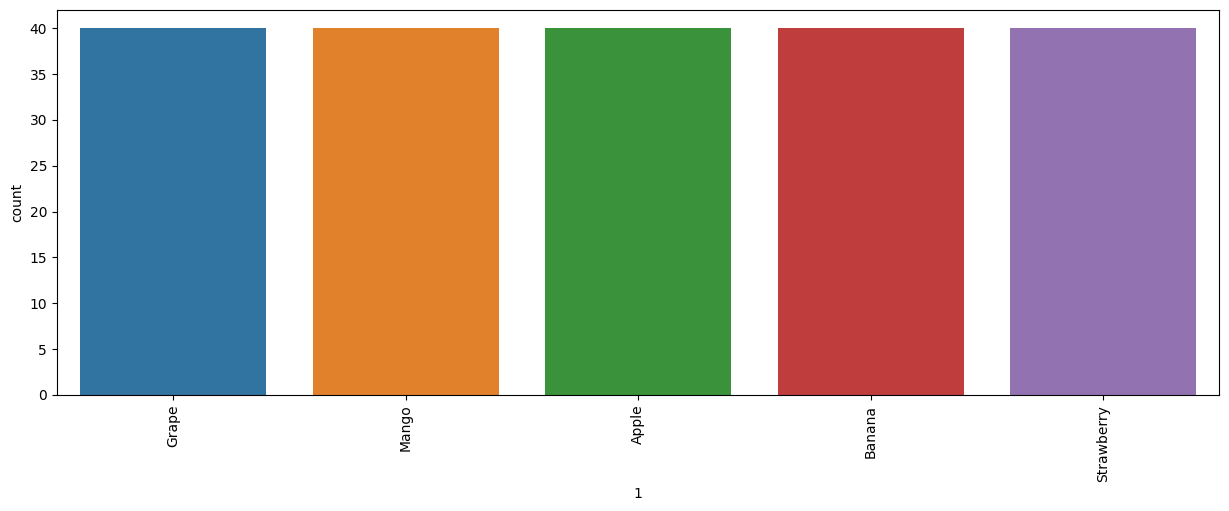

In [7]:
valImgPath = pd.Series(val_img_paths).astype(str)
valLabels=pd.Series(val_labels)
valData = pd.concat([valImgPath,valLabels],axis=1)
display(Markdown("#*Count Plot of Validation data in data set:*"))
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
sns.countplot(x=valData[1], order=valData[1].value_counts().index)

#*Count Plot of Test data in data set:*

<Axes: xlabel='1', ylabel='count'>

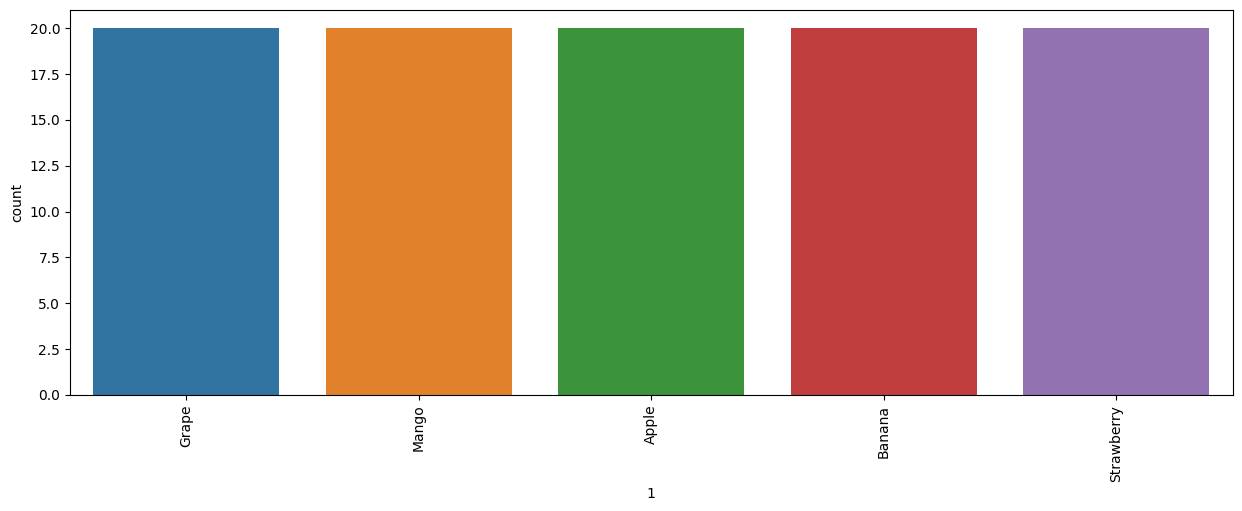

In [8]:
testImgPath = pd.Series(test_img_paths).astype(str)
testLabels=pd.Series(test_labels)
testData = pd.concat([testImgPath,testLabels],axis=1)
display(Markdown("#*Count Plot of Test data in data set:*"))
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
sns.countplot(x=testData[1], order=testData[1].value_counts().index)

In [9]:
train_gen = ImageDataGenerator()
aug_gen = ImageDataGenerator(
          rotation_range=10, # rotation
          width_shift_range=0.2, # horizontal shift
          height_shift_range=0.2, # vertical shift
          zoom_range=0.2, # zoom
          horizontal_flip=True, # horizontal flip
          brightness_range=[0.2,1.2]) # brightness
val_gen = ImageDataGenerator()
test_gen = ImageDataGenerator()

train_data = train_gen.flow_from_dataframe(
    dataframe = trainData,
    x_col = 0,
    y_col = 1,
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True
)

aug_data = aug_gen.flow_from_dataframe(
    dataframe = trainData,
    x_col = 0,
    y_col = 1,
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True
)

val_data = val_gen.flow_from_dataframe(
    dataframe = valData,
    x_col = 0,
    y_col = 1,
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True
)

test_data = test_gen.flow_from_dataframe(
    dataframe = testData,
    x_col = 0,
    y_col = 1,
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False
)


Found 9700 validated image filenames belonging to 5 classes.
Found 9700 validated image filenames belonging to 5 classes.
Found 200 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.


In [12]:
from keras.models import model_from_json

json_file = open('/content/modelv2_32.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("/content/modelv2_32.h5")
model.compile(
    optimizer = tf.optimizers.SGD(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
def combine_gen(*gens):
    while True:
        for g in gens:
            yield next(g)

In [14]:
history1 = model.fit(combine_gen(train_data, aug_data), steps_per_epoch=len(train_data)+len(aug_data), epochs=10, validation_data=val_data)

Epoch 1/10
608/608 [==============================] - 380s 585ms/step - loss: 0.1734 - accuracy: 0.9465 - val_loss: 0.6240 - val_accuracy: 0.8300
Epoch 2/10
608/608 [==============================] - 351s 577ms/step - loss: 0.1567 - accuracy: 0.9512 - val_loss: 0.6561 - val_accuracy: 0.8250
Epoch 3/10
608/608 [==============================] - 351s 578ms/step - loss: 0.1509 - accuracy: 0.9541 - val_loss: 1.4963 - val_accuracy: 0.6400
Epoch 4/10
608/608 [==============================] - 352s 579ms/step - loss: 0.1679 - accuracy: 0.9493 - val_loss: 0.8344 - val_accuracy: 0.7750
Epoch 5/10
608/608 [==============================] - 349s 574ms/step - loss: 0.1512 - accuracy: 0.9538 - val_loss: 3.3310 - val_accuracy: 0.4050
Epoch 6/10
608/608 [==============================] - 354s 582ms/step - loss: 0.1725 - accuracy: 0.9460 - val_loss: 0.6424 - val_accuracy: 0.8250
Epoch 7/10
608/608 [==============================] - 350s 576ms/step - loss: 0.1362 - accuracy: 0.9584 - val_loss: 0.5502 -

In [16]:

h1accuracy = [0.3615, 0.4794, 0.5110, 0.5368, 0.5580, 0.5660, 0.6013, 0.6128, 0.6404, 0.6564]
h1val_accuracy = [0.4250, 0.3850, 0.4650, 0.4550, 0.2700, 0.4000, 0.2400, 0.4550, 0.3750, 0.5700]
h1val_loss = [1.4278, 1.3849, 1.2094, 1.2668, 1.8774, 1.5616, 1.6658, 1.2281, 1.3890, 1.4851]
h1loss = [1.5052, 1.2602, 1.1749, 1.1209, 1.0785, 1.0645, 1.0114, 0.9888, 0.9338, 0.8989]

h2accuracy = [0.6722, 0.6895, 0.7026, 0.7127, 0.7265, 0.7285, 0.7472, 0.7608, 0.7742, 0.7834]
h2val_accuracy = [0.6500, 0.6600, 0.5150, 0.4800, 0.5050, 0.4900, 0.4550, 0.6500, 0.5950, 0.7350]
h2val_loss = [0.9239, 0.8411, 1.1427, 1.2086, 2.0010, 1.3858, 1.4463, 0.9214, 1.2307, 0.7774]
h2loss = [0.8676, 0.8312, 0.7978, 0.7795, 0.7374, 0.7361, 0.6976, 0.6622, 0.6275, 0.6012]

h3accuracy = [0.7952, 0.8029, 0.8124, 0.8182, 0.8301, 0.8361, 0.8511, 0.8561, 0.8624, 0.8751]
h3val_accuracy = [0.6800, 0.4700, 0.4900, 0.7050, 0.4450, 0.7450, 0.4100, 0.4700, 0.6450, 0.6000]
h3val_loss = [0.9205, 1.6522, 1.3769, 0.8506, 2.2953, 0.7143, 2.0042, 2.4484, 1.8110, 1.5971]
h3loss = [0.5788, 0.5548, 0.5321, 0.5185, 0.4878, 0.4769, 0.4348, 0.4289, 0.4102, 0.3733]

h4accuracy = [0.8818, 0.8832, 0.8822, 0.8978, 0.9051, 0.9059, 0.9097, 0.9182, 0.9193, 0.9228]
h4val_accuracy = [0.7000, 0.3500, 0.7250, 0.6500, 0.7000, 0.2900, 0.8300, 0.5800, 0.7200, 0.8500]
h4val_loss = [1.1730, 4.2095, 0.8388, 1.4306, 1.1743, 4.1755, 0.5022, 1.7245, 1.0644, 0.5313]
h4loss = [0.3547, 0.3472, 0.3566, 0.3168, 0.2982, 0.2888, 0.2903, 0.2571, 0.2607, 0.2442]


h5accuracy = [0.9279, 0.9302, 0.9311, 0.9321, 0.9356, 0.9237, 0.9371, 0.9398, 0.9453, 0.9472]
h5val_accuracy = [0.8150, 0.7550, 0.8350, 0.8100, 0.5200, 0.6550, 0.6400, 0.8450, 0.7950, 0.6250]
h5val_loss = [0.5535, 0.8270, 0.5105, 0.5856, 3.7668, 1.4083, 2.1009, 0.4906, 0.7896, 1.5105]
h5loss = [0.2295, 0.2208, 0.2187, 0.2173, 0.2078, 0.2468, 0.1979, 0.1924, 0.1780, 0.170]

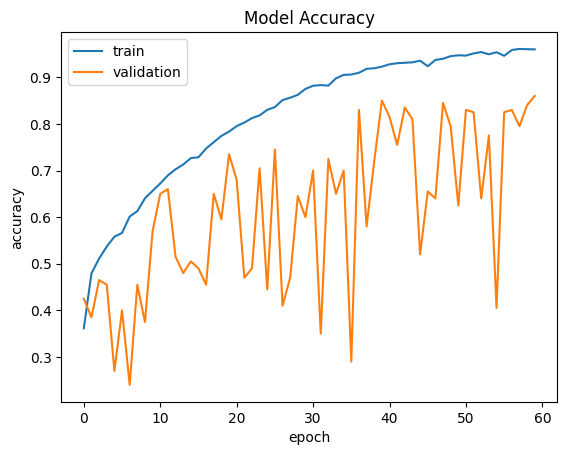

In [17]:
plt.plot(h1accuracy+h2accuracy+h3accuracy+h4accuracy+h5accuracy+history1.history['accuracy'])
plt.plot(h1val_accuracy+h2val_accuracy+h3val_accuracy+h4val_accuracy+h5val_accuracy+history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

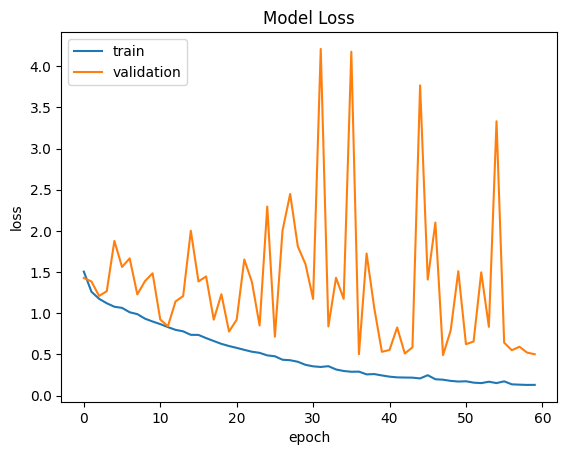

In [18]:
plt.plot(h1loss+h2loss+h3loss+h4loss+h5loss+history1.history['loss'])
plt.plot(h1val_loss+h2val_loss+h3val_loss+h4val_loss+h5val_loss+history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [19]:
pred = model.predict(test_data)
pred = np.argmax(pred,axis=1)
print(classification_report(test_data.labels,pred))

4/4 [==============================] - 1s 172ms/step
              precision    recall  f1-score   support

           0       0.68      0.75      0.71        20
           1       0.85      0.85      0.85        20
           2       1.00      0.90      0.95        20
           3       0.85      0.85      0.85        20
           4       0.85      0.85      0.85        20

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



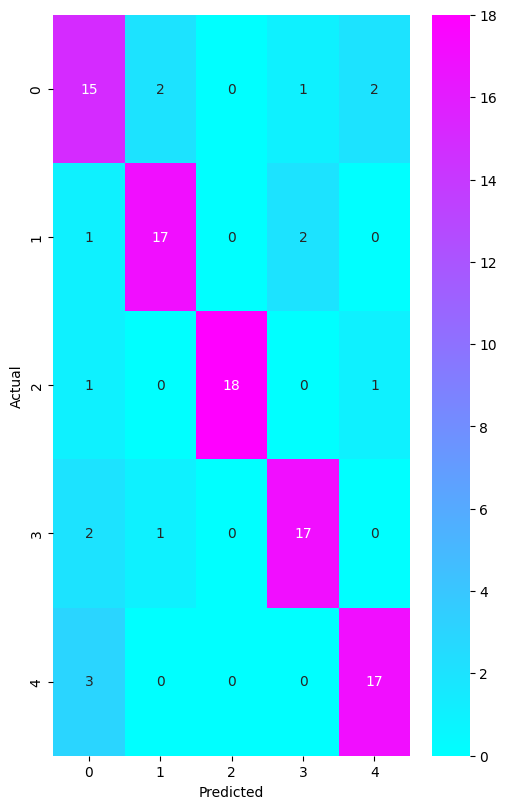

In [20]:
classes=[i for i in range(5)]
con_mat_df = pd.DataFrame(confusion_matrix(test_data.labels,pred),
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(5, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.cool,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [21]:
model_json = model.to_json()
with open("/content/modelv2_3_.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/modelv2_3_.h5")
print("Saved model to disk")

Saved model to disk


In [22]:
train_data.class_indices

{'Apple': 0, 'Banana': 1, 'Grape': 2, 'Mango': 3, 'Strawberry': 4}